# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

<font color='green'>**Answer 1**</font>

One can use either **f-divergences** or **integral probability metrics** to compare probability distributions.

__f-divergences__:<br>
Assume that $p_D$ and $p_\theta$ are absolutely continuous with respect to the same measure $\mu$ (for example Lebesgue measure on $\mathbb R^d$ or a counting measure), with densities $q_D$ and $q_\theta$. Let $f:\mathbb R \to \mathbb R$ a convex function with $f(1)=0$. The **$f$-divergence** between $p_D$ and $p_\theta$ is defined as $$D_f(p_D||p_\theta):= \int  f\left(\frac{q_D(x)}{q_\theta(x)}\right) q_\theta(x) d\mu(x)$$
Note that $D_f$ may not be symmetric and the triangle inequality may not hold, hence the name *divergence* instead of *distance*. However, $f$-divergences satisfy the positivity property: $D_f(p_D||p_\theta) = 0 \iff p_D=p_\theta$.

Some examples of $f$ are:  
- $f:t\mapsto t\log t$ corresponding to the Kullback-Leibler divergence. 
- $f:t\mapsto \frac 12 (\sqrt t -1)^2$ corresponding to the Hellinger distance. 
- $f:t\mapsto \frac 12 |t-1|$ corresponding to the total variation distance.

__Integral probability metrics__:<br>
Let $\mathcal X$ be the data space. **Integral probability metrics** (IPMs) are defined by:
$$d_{\mathcal F}(p_D||p_\theta) := \sup_{f\in \mathcal F}\; E_{x\sim p_D}[f(x)] - E_{x\sim p_\theta}[f(x)]$$
where $\mathcal F$ is a class of functions from $\mathcal X$ to $\mathbb R$. Note that IPMs are easier to define since they not require density assumptions on the probability distributions. Furthermore, if $f\in \mathcal F \implies -f\in \mathcal F$, then $d_\mathcal F$ is symmetric and satisfies the triangle inequality.

Some examples of $\mathcal F$ are:  
- $\mathcal F = \{\text{1-Lipschitz functions}\}$ yielding the Wasserstein-1 distance (also called Earth-Mover distance)  
- $\mathcal F = \{\text{measurable bounded functions with values in }[-1,1]\}$ yielding the total variation distance (which is therefore at the intersection between IPMs and $f$-divergences)  
- $\mathcal F = \{\text{unit ball of an RKHS}\}$ yielding the Maximum Mean Discrepancy (MMD).

***

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

<font color='green'>**Answer 2**</font>

When the dimension of $\theta$ is large (e.g. the case where the generator is a neural network), computing the density $p_\theta(x)$ is intractable. Besides, the density $p_D$ is unknown.

In order to be used as part of the loss function, the methods that hinge on densities and expectations need empirical counterparts (e.g. by writing $f$-divergences as expectations and in turn approaching these expectations with sample means). With the empirical versions, one only needs to sample from $p_\theta$ and $p_D$ efficiently.

Moreover, in order to optimize the loss, the mapping $\theta \mapsto p_\theta$ has to be smooth enough.


***

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

<font color='green'>**Answer 3**</font>

Values of $N$ greater than $50$ lead to the curse of dimensionality: samples from $\mathcal{N}(0;I)$ will all be at distance $\sqrt N$ from the origin (with high probability). As a result, if one interpolates linearly between two samples $\epsilon$ and $\epsilon'$, one will traverse locations with very low probability (hence making the corresponding outputs of the generator less meaningful).

***

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

<font color='green'>**Answer 4**</font>

Assuming that the discriminator has been trained to optimimality, one is tempted to perform gradient steps on $\theta$, however this does not work.

In practice, as the discriminator gets better, the updates to the generator get worse. In his seminal paper Goodfellow indicates that when the generator is poor, the discriminator can reject samples with high confidence, thus the term $\mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right]$ is almost $0$, so the gradient vanishes, hence the generator cannot improve.

***

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

<font color='green'>**Answer 5**</font>

This loss only returns feedback on the *quality* of the outputs of the generator, regardless of their *diversity* (representativeness of the real data). A generator could thus return the exact same high-quality sample and get very low loss. This is usually referred to as *mode collapse*.

***

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [12]:
import torch
import math
from sklearn import datasets
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data).to(device)

Let's plot a large batch, to see what the dataset looks like.

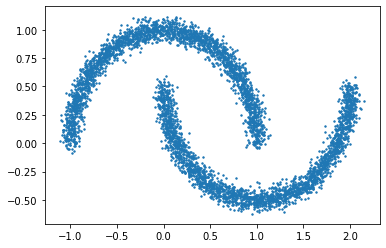

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 2)
        
    def __call__(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        h = F.relu(self.fc5(h))
        return h
    
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0).to(device)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc3(h)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: 1.421e+00, generator: 5.462e-01


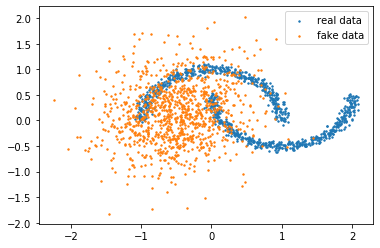

step 3000: discriminator: 1.386e+00, generator: 6.933e-01


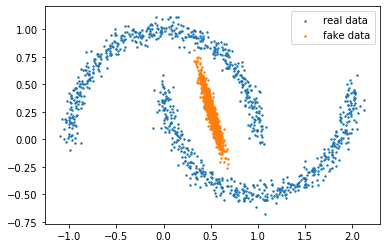

step 6000: discriminator: 1.386e+00, generator: 6.932e-01


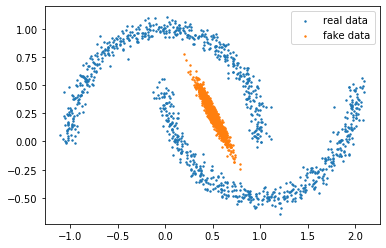

step 9000: discriminator: 1.386e+00, generator: 6.930e-01


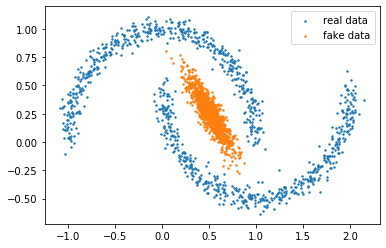

step 12000: discriminator: 1.386e+00, generator: 6.929e-01


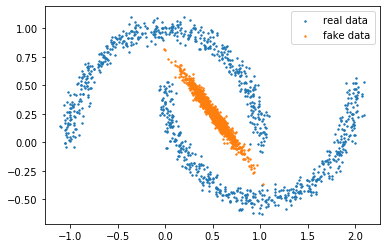

step 15000: discriminator: 1.386e+00, generator: 6.929e-01


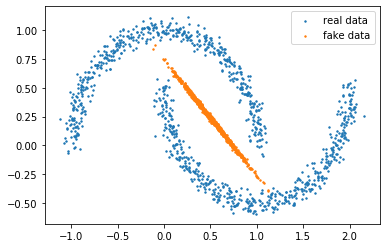

step 18000: discriminator: 1.386e+00, generator: 6.933e-01


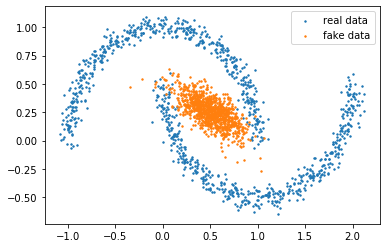

In [7]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 2
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 64

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
        disc_loss = torch.mean(F.softplus(-discriminator(real_batch)) + F.softplus(discriminator(fake_batch)))
        #
        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    # == COMPUTE THE GENERATOR LOSS HERE
    gen_loss = torch.mean(F.softplus(-discriminator(fake_batch)))
    #
    gen_loss.backward()
    optim_gen.step()
    if i%3000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

<font color='green'>**Answer 6**</font>

As noted in question 5 the generator can just sample the same high-quality sample over and over again to achieve low loss.
***

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

<font color='green'>**Answer 7**</font>

**depth / width of the generator network**: I noticed that two hidden layers were not expressive enough, and that more than five led to slower training and worse performance. It also seems that increasing the width above $\sim 200$ does not help.

**depth / width of the discriminator network**: I noticed that making the discriminator more complex (i.e adding layers or increasing width) strongly encourages mode collapse.

**impact of TRAIN_RATIO**: A value of $3$ gave the best results for my architecture. I would get mode collapse when it was either too low or too high.

***

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

<font color='green'>**Answer 8**</font>

Assuming that both $p_D$ and $p_\theta$ have densities, $$D_{KL}(p_D \| p_\theta) = E_{x\sim p_D}\left(\log \frac{p_D(x)}{p_\theta(x)} \right) = E_{x\sim p_D}(\log p_D(x)) - E_{x\sim p_D}(\log p_\theta(x))$$

Since $E_{x\sim p_D}(\log p_D(x))$ is independent of $\theta$, minimizing $D_{KL}(p_D \| p_\theta)$ is equivalent to maximizing $E_{x\sim p_D}(\log p_\theta(x))$.

***

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> (Write your answer here)

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

 <font color='green'>**Answer 10**</font>

The KL divergence between multivariate Gaussians is given by:
$$D_{KL}(\mathcal N_d(\mu_1, \Sigma_1)||\mathcal N_d(\mu_2, \Sigma_2)) =  \frac{1}{2}\left[\log\frac{|\Sigma_2|}{|\Sigma_1|} - d + Tr(\Sigma_2^{-1}\Sigma_1) + (\mu_2 - \mu_1)^T \Sigma_2^{-1}(\mu_2 - \mu_1)\right]$$

Here this yields $$D_{KL}(q_\phi(z | x) \| p(z)) = \frac 12 \left[-\sum_i \log(\sigma_\phi(x)_i) - d + \sum_i \sigma_\phi(x)_i + \|\mu_\phi(x)\|_2^2  \right]$$

***

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

<font color='green'>**Answer 11**</font>

A straightforward computation yields 

$$-\log p_\theta(x | z) = \displaystyle \frac{N}{2}\log(2\pi)+\frac{1}{2} \log(|Diag(\sigma_\theta(z))|) + \frac{1}{2} (x - \mu_\theta(z))^T Diag(\sigma_\theta(z))^{-1} (x - \mu_\theta(z))$$

***

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [10]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc_mu = nn.Linear(64, LATENT_N)
        self.fc_logvar = nn.Linear(64, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(LATENT_N, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc_mu = nn.Linear(128, 2)
        self.fc_logvar = nn.Linear(128, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        h = F.elu(self.fc1(z))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0).to(device)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

step 0: KL: 1.010e+01, rec: 1.216e+00


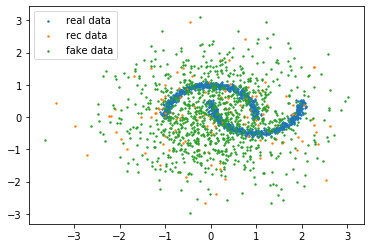

step 1000: KL: 1.819e+01, rec: -1.861e+01


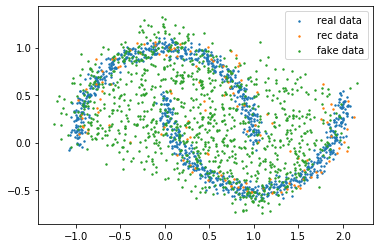

step 2000: KL: 1.929e+01, rec: -2.206e+01


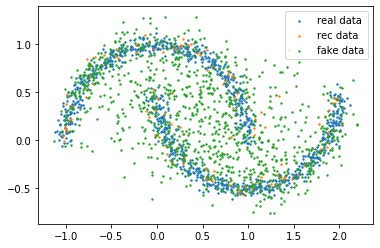

step 3000: KL: 1.991e+01, rec: -2.396e+01


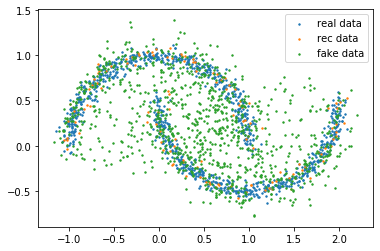

step 4000: KL: 2.050e+01, rec: -2.432e+01


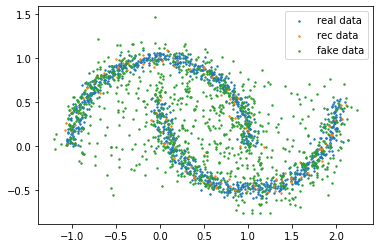

step 5000: KL: 2.079e+01, rec: -2.565e+01


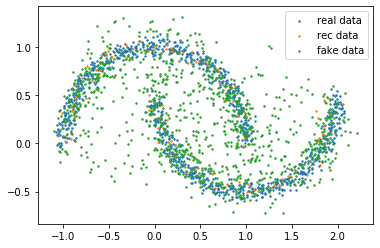

step 6000: KL: 2.073e+01, rec: -2.574e+01


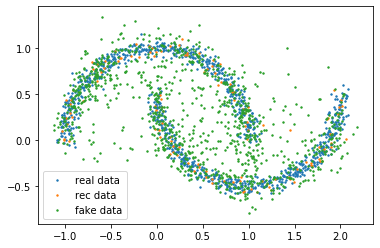

step 7000: KL: 2.097e+01, rec: -2.711e+01


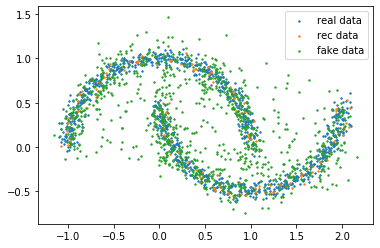

step 8000: KL: 2.135e+01, rec: -2.462e+01


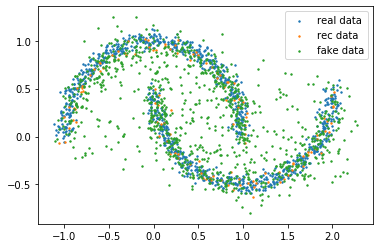

step 9000: KL: 2.131e+01, rec: -2.793e+01


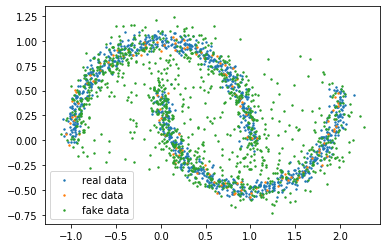

step 10000: KL: 2.193e+01, rec: -2.697e+01


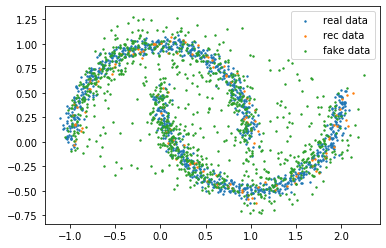

step 11000: KL: 2.181e+01, rec: -2.629e+01


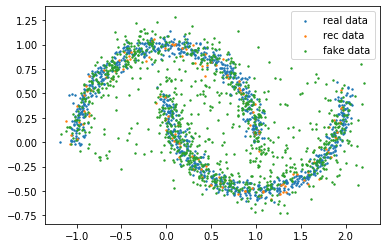

step 12000: KL: 2.224e+01, rec: -2.704e+01


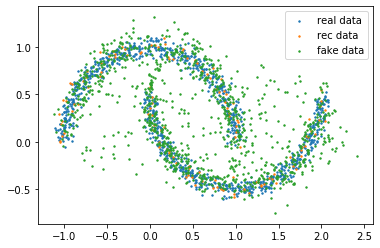

step 13000: KL: 2.197e+01, rec: -2.634e+01


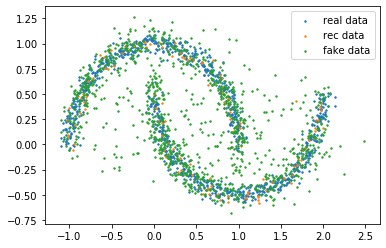

step 14000: KL: 2.217e+01, rec: -2.663e+01


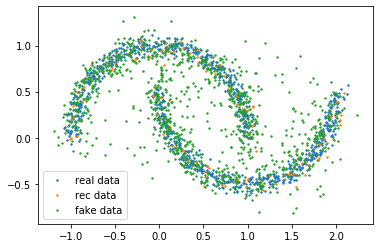

step 15000: KL: 2.234e+01, rec: -2.950e+01


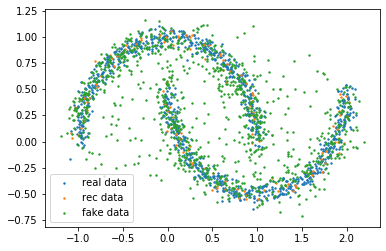

step 16000: KL: 2.243e+01, rec: -2.753e+01


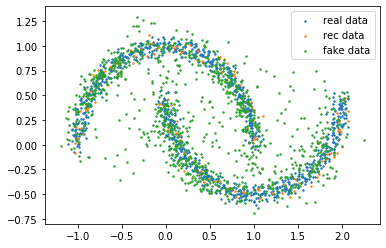

step 17000: KL: 2.245e+01, rec: -2.899e+01


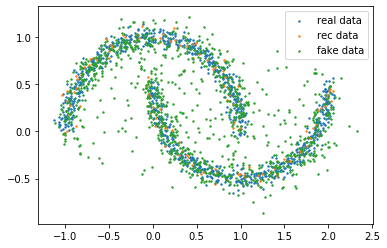

step 18000: KL: 2.256e+01, rec: -2.890e+01


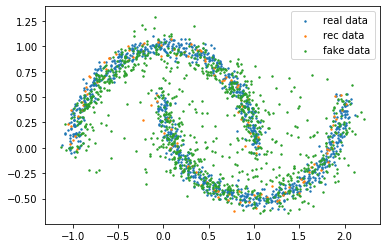

step 19000: KL: 2.261e+01, rec: -2.994e+01


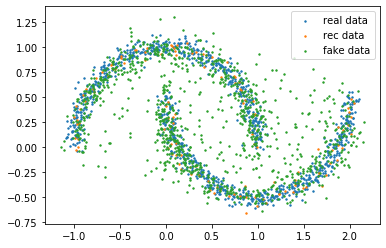

step 20000: KL: 2.272e+01, rec: -2.783e+01


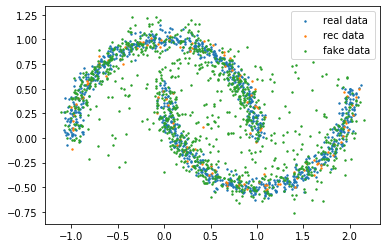

step 21000: KL: 2.300e+01, rec: -3.085e+01


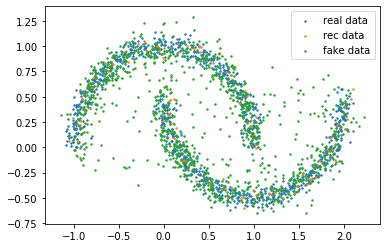

step 22000: KL: 2.272e+01, rec: -2.879e+01


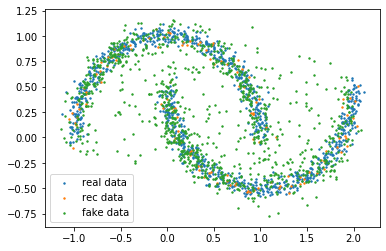

step 23000: KL: 2.288e+01, rec: -3.098e+01


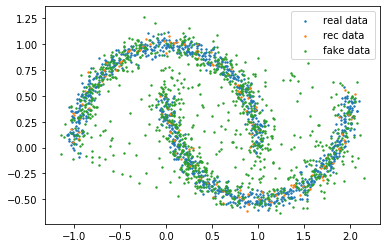

step 24000: KL: 2.291e+01, rec: -3.145e+01


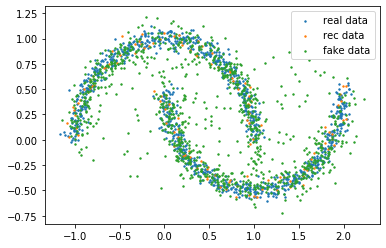

step 25000: KL: 2.312e+01, rec: -3.185e+01


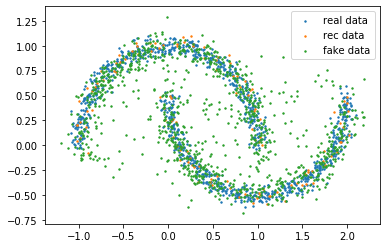

step 26000: KL: 2.300e+01, rec: -3.160e+01


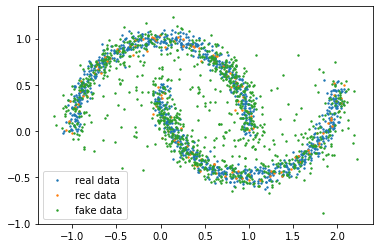

step 27000: KL: 2.308e+01, rec: -3.161e+01


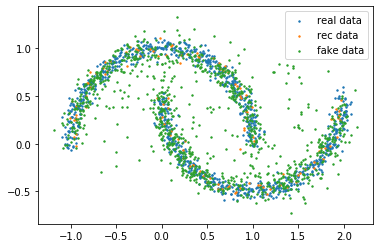

step 28000: KL: 2.316e+01, rec: -2.840e+01


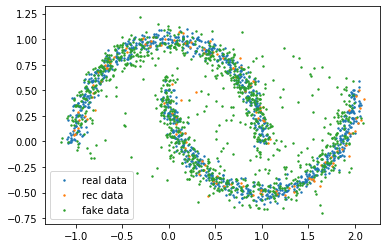

step 29000: KL: 2.326e+01, rec: -3.149e+01


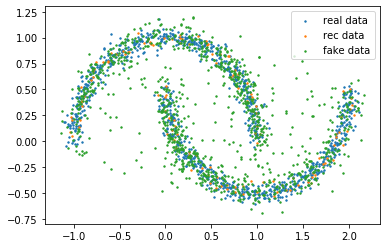

step 30000: KL: 2.331e+01, rec: -3.211e+01


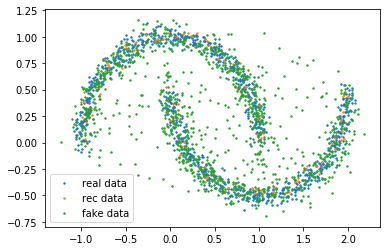

step 31000: KL: 2.355e+01, rec: -3.151e+01


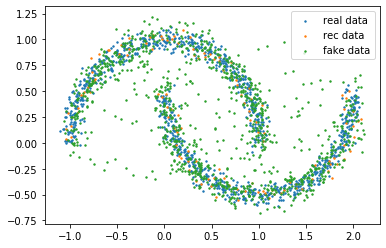

step 32000: KL: 2.351e+01, rec: -3.162e+01


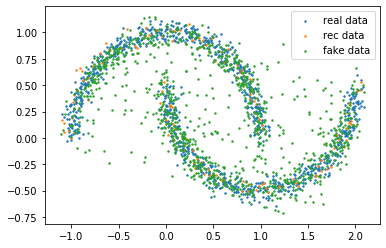

step 33000: KL: 2.336e+01, rec: -3.140e+01


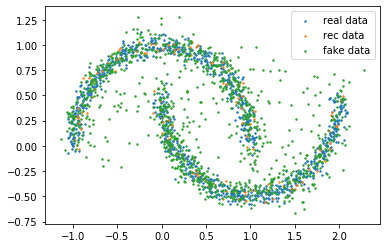

step 34000: KL: 2.347e+01, rec: -3.235e+01


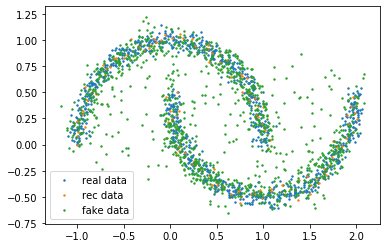

step 35000: KL: 2.340e+01, rec: -3.234e+01


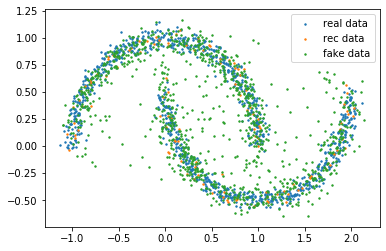

step 36000: KL: 2.348e+01, rec: -3.284e+01


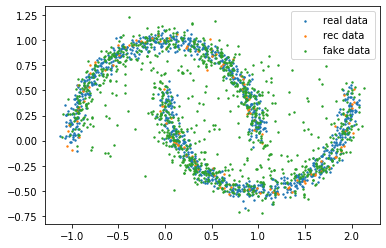

step 37000: KL: 2.345e+01, rec: -3.247e+01


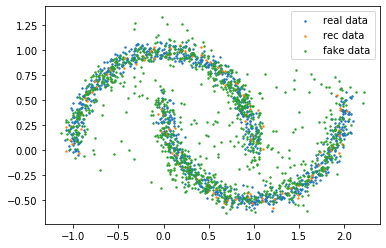

step 38000: KL: 2.345e+01, rec: -3.280e+01


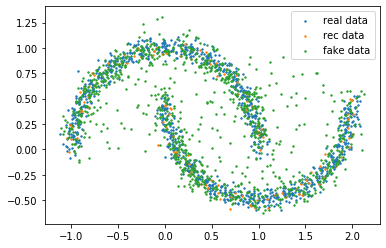

step 39000: KL: 2.384e+01, rec: -3.136e+01


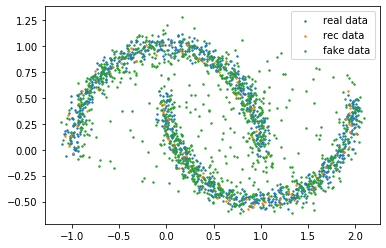

step 40000: KL: 2.369e+01, rec: -3.273e+01


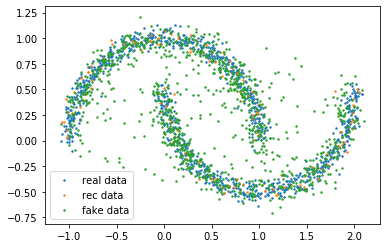

In [13]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = torch.mean(torch.sum(torch.exp(enc_logvar),1)+ torch.sum(enc_mu*enc_mu,1)- torch.sum(enc_logvar,1)).to(device)
    #
    # SAMPLE z FROM q(z|x) HERE
    #
    z = (torch.normal(torch.zeros(BATCHLEN, LATENT_N),1)* torch.exp(0.5*enc_logvar)+ enc_mu).to(device)
    
    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    loss_rec = torch.mean(2*torch.sum(dec_logvar,1)+ torch.sum(torch.exp(-dec_logvar)*(x-dec_mu)*(x-dec_mu),1)).to(device)
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

> (Write your answer here)

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

> (Write your answer here)

### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$. 
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**

> (Write your answer here)

Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**

> (Write your answer here)

A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](realNVPforward.png)

**Q16: Show that the defined mapping is indeed invertible**

> (Write your answer here)

**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

> (Write your answer here)

**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super().__init__()
        ### define here variables to use in f and s ###
        
        ###
        self.mask = mask #we use the mask variable to make the cut in input

    def sfun(self, x_m):
        return x_m
        
    def tfun(self, x_m):
        return x_m
        
    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        return y

In [ ]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [ ]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [ ]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [ ]:
from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

In [ ]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

> (Write your answer here)

**Q20: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs and Normalizing flows?**

> (Write your answer here)